In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression, f_regression 
import numpy as np
import seaborn as sns

In [2]:
data_file = '../SeoulBikeData.csv'
df = pd.read_csv(data_file, encoding='ISO-8859-1')


In [3]:
# convert "Holiday" into binary: 0 = "No Holiday", 1 = "Holiday"
df.loc[df.Holiday == "No Holiday", "Holiday"] = 0
df.loc[df.Holiday == "Holiday", "Holiday"] = 1
# convert "Functioning Day" into binary: 1 = "Yes", 0 = "No"
df.loc[df["Functioning Day"] == "Yes", "Functioning Day"] = 1
df.loc[df["Functioning Day"] == "No", "Functioning Day"] = 0
# # map seasons onto numeric values
seasons_dict = {
    "Winter": 0, "Spring": 1, "Summer": 2, "Autumn": 3
}
df.replace({"Seasons": seasons_dict}, inplace=True)

/var/folders/xm/fbpr6wj166n5b1320_w6jjnc0000gn/T/ipykernel_23228/2691239714.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({"Seasons": seasons_dict}, inplace=True)


In [4]:
# downsample data to daily
dates = pd.date_range('2017-12-01', freq='h', periods = 24*365)
df.set_index(dates, inplace=True)
df_daily = df.drop(columns=["Date","Hour"]).resample('D').mean()
# for the target variable, we probably want the total bikes rented, not the mean
df_daily["Rented Bike Count"] = df.resample('D').sum()["Rented Bike Count"]

In [5]:
# remove data where functioning data is "No" (now 0)
df_daily.drop(df_daily[df_daily["Functioning Day"] != 1.0].index, inplace=True)


len(df_daily)

352

In [49]:
# build a pipeline to streamline the process
steps = [
    ('feature_selection', SelectKBest(r_regression, k=6)),
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=10)),
    ('model', Ridge(alpha=50, fit_intercept=True))
]
pipeline = Pipeline(steps)

In [7]:
# create feature array, target vector 
dates = pd.date_range('2017-12-01', freq='h', periods = 24*365)
# df_t = df_daily.drop(columns=[ "Rented Bike Count", "Functioning Day"])
df_t = df.drop(columns=["Rented Bike Count", "Functioning Day","Date"])
# xt = df_t.to_numpy()
# remove the first column, which just has the index
# X = xt[:,1:]

y = df["Rented Bike Count"].to_numpy()
# y = df_daily["Rented Bike Count"].to_numpy()
# normalize the features before training
# scaler = preprocessing.StandardScaler().fit(X)
# X_scaled = scaler.transform(X)

In [12]:
# feature selection
selector = SelectKBest(r_regression, k=8)
selector.fit_transform(df_t, y)
# Get columns to keep and create new dataframe with those only
cols_idxs = selector.get_support(indices=True)
df_best_features = df_t.iloc[:,cols_idxs]
df_best_features

,Hour,Temperature(°C),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Seasons,Holiday
2017-12-01 00:00:00,0,-5.2,2.2,2000,-17.6,0.0,0,0
2017-12-01 01:00:00,1,-5.5,0.8,2000,-17.6,0.0,0,0
2017-12-01 02:00:00,2,-6.0,1.0,2000,-17.7,0.0,0,0
2017-12-01 03:00:00,3,-6.2,0.9,2000,-17.6,0.0,0,0
2017-12-01 04:00:00,4,-6.0,2.3,2000,-18.6,0.0,0,0
...,...,...,...,...,...,...,...,...
2018-11-30 19:00:00,19,4.2,2.6,1894,-10.3,0.0,3,0
2018-11-30 20:00:00,20,3.4,2.3,2000,-9.9,0.0,3,0
2018-11-30 21:00:00,21,2.6,0.3,1968,-9.9,0.0,3,0
2018-11-30 22:00:00,22,2.1,1.0,1859,-9.8,0.0,3,0


In [8]:
# split data 
X_train, X_test, y_train, y_test = train_test_split(df_t, y, test_size=0.3)

In [50]:
pipeline.fit(X_train, y_train)
print('Training score: {}'.format(pipeline.score(X_train, y_train)))
print('Test score: {}'.format(pipeline.score(X_test, y_test)))

Training score: 0.8220001324809487
Test score: 0.7334859452939431


In [8]:
# fit a ploynomial regesssion model - old original method
# poly = PolynomialFeatures(degree=2, include_bias=False)
# poly_features = poly.fit_transform(X_scaled)

# reg = Ridge(alpha=0.9).fit(poly_features, y)
# reg.score(poly_features, y)
df_t

,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday
2017-12-01 00:00:00,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,0
2017-12-01 01:00:00,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,0
2017-12-01 02:00:00,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,0
2017-12-01 03:00:00,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,0
2017-12-01 04:00:00,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...
2018-11-30 19:00:00,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,3,0
2018-11-30 20:00:00,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,3,0
2018-11-30 21:00:00,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,3,0
2018-11-30 22:00:00,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,3,0


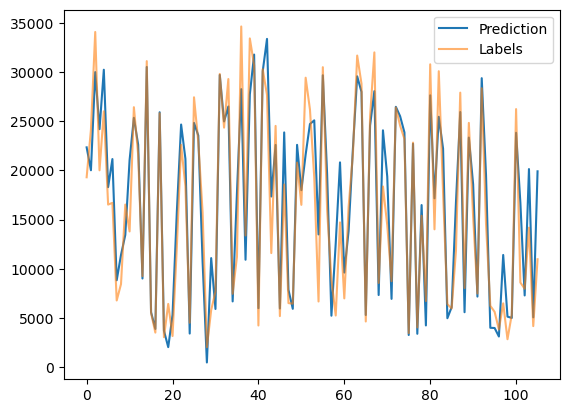

In [14]:
pred = pipeline.predict(X_test)

ss1, ss2 = 0, None

plt.plot(pred[ss1:ss2], label = 'Prediction')
plt.plot(y_test[ss1:ss2], label = 'Labels', alpha = 0.6)

plt.legend()

<Axes: >

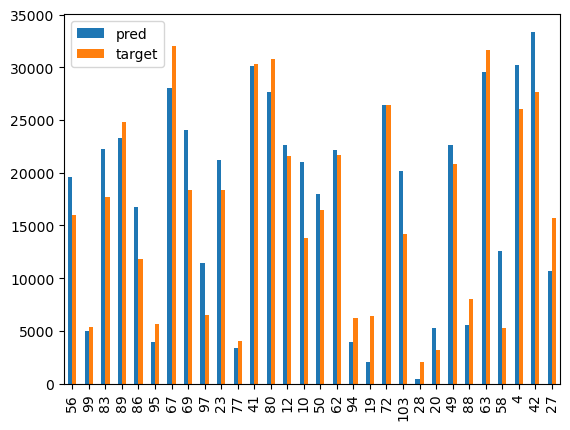

In [17]:
df_p = pd.DataFrame(data = np.vstack( (pred, y_test) ).transpose(),
                   columns= ['pred', 'target'])
df_p.sample(n=30).plot.bar()

Text(0.5, 0, 'Temperature(°C)')

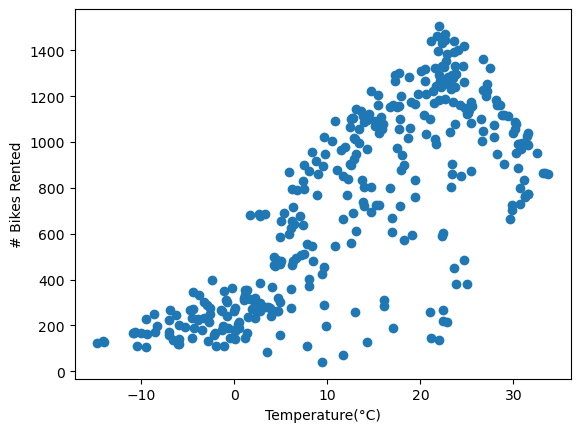

In [18]:
# Some visualizations of the data
plt.scatter(df_daily["Temperature(°C)"], df_daily["Rented Bike Count"])
plt.ylabel("# Bikes Rented")
plt.xlabel("Temperature(°C)")

Text(0.5, 0, 'Seasons')

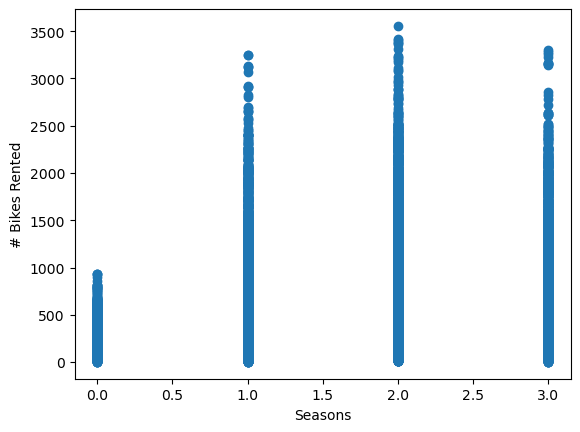

In [48]:
# plt.scatter(df["Dew point temperature(°C)"], df["Rented Bike Count"])
# plt.ylabel("# Bikes Rented")
# plt.xlabel("Dew point temperature(°C)")
plt.scatter(df["Seasons"], df["Rented Bike Count"])
plt.ylabel("# Bikes Rented")
plt.xlabel("Seasons")

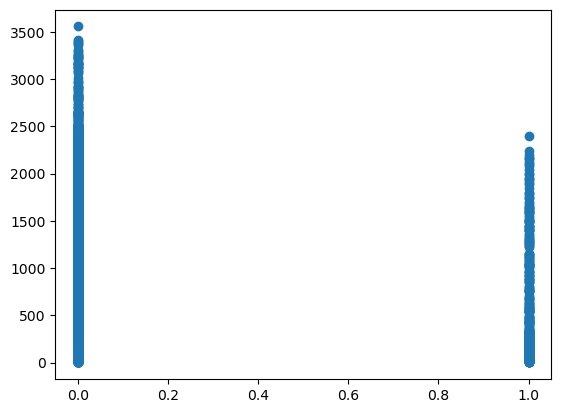

In [49]:
plt.scatter(df["Holiday"], df["Rented Bike Count"])

<Axes: ylabel='Frequency'>

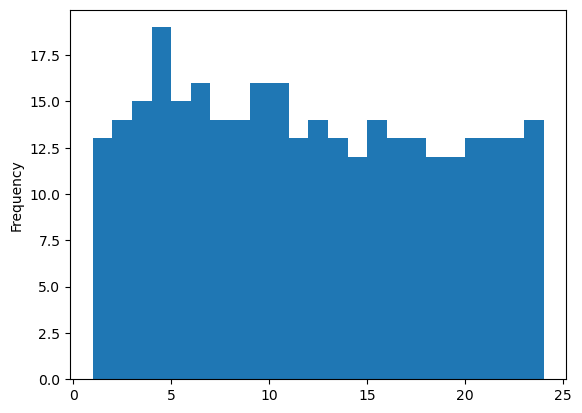

In [9]:
df[df["Rented Bike Count"] < 10]["Hour"].plot.hist(bins=np.arange(1,25))

<Axes: xlabel='Hour'>

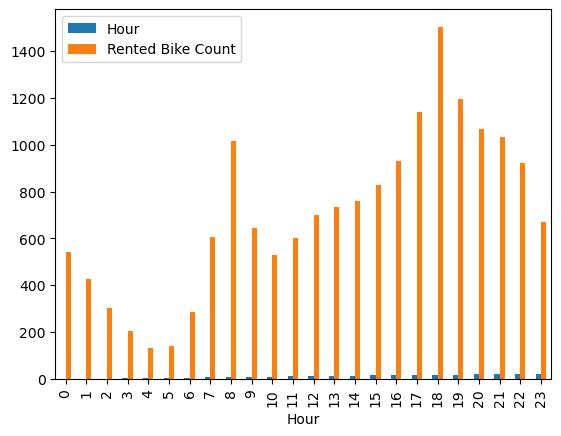

In [16]:
# plt.hist(x=df["Rented Bike Count"], bins=df["Hour"])
df[["Hour","Rented Bike Count"]].groupby(df["Hour"]).mean().plot.bar()

/var/folders/xm/fbpr6wj166n5b1320_w6jjnc0000gn/T/ipykernel_23228/220879367.py:3: RankWarning: Polyfit may be poorly conditioned
  poly_coef = np.polyfit(x, data, deg=20)


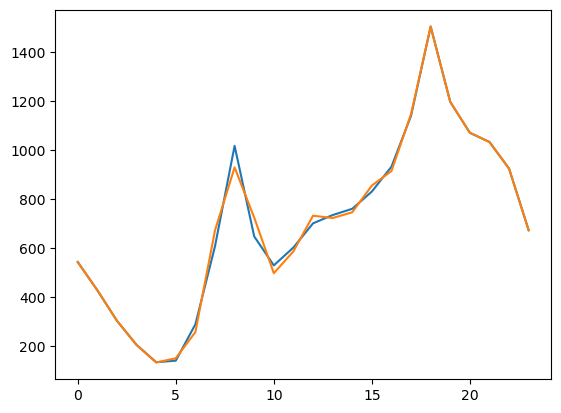

In [36]:
data = df[["Hour","Rented Bike Count"]].groupby(df["Hour"]).mean()["Rented Bike Count"].to_numpy()
x = np.arange(0,24)
poly_coef = np.polyfit(x, data, deg=20)
poly_fit = np.polyval(poly_coef, x)

plt.plot(x, data)
plt.plot(x, poly_fit)

In [31]:
data

<bound method IndexOpsMixin.to_numpy of Hour
0      541.460274
1      426.183562
2      301.630137
3      203.331507
4      132.591781
5      139.082192
6      287.564384
7      606.005479
8     1015.701370
9      645.983562
10     527.821918
11     600.852055
12     699.441096
13     733.246575
14     758.824658
15     829.186301
16     930.621918
17    1138.509589
18    1502.926027
19    1195.147945
20    1068.964384
21    1031.449315
22     922.797260
23     671.126027
Name: Rented Bike Count, dtype: float64>